In [7]:
from tomoSegmentPipeline.utils import setup
from tomoSegmentPipeline.dataloader import to_categorical, transpose_to_channels_first
from tomoSegmentPipeline.trainWrapper import make_trainer
from tomoSegmentPipeline.showcaseResults import load_model as _load_model
from tomoSegmentPipeline.dataloader import tomoSegment_dataset
from tomoSegmentPipeline.losses import Tversky_index, Tversky_loss, Tversky1_loss


from torch.utils.data import DataLoader
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from glob import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from tqdm import tqdm

PARENT_PATH = setup.PARENT_PATH

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# Moving this files from denbi to FastFaraday, but first we need to rename
# files = glob('/home/ubuntu/Thesis/data/membraneSegmentation/model_logs/incremental_models/logs/BaselineModel/Deconv/train02-03-17/*/version_*/*', recursive=True)

# for f in files:
#     if 'version_2' not in f:
#         new_f = f.replace('version_0', 'version_4').replace('version_1', 'version_3')
#         new_f = new_f.replace('0_trainer', '4_trainer').replace('1_trainer', '3_trainer')
#         new_f = new_f.replace('0.model', '4.model').replace('1.model', '3.model')
#         os.system('mv %s %s' %(f, new_f))

# files = glob('/home/ubuntu/Thesis/data/membraneSegmentation/model_logs/incremental_models/logs/BaselineModel/Deconv/train02-03-17/*/version_*/')

# for f in files:
#     if 'version_2' in f:
#         os.system('rm -r %s' %f)

# S2SDenoised folder
# files = glob('/home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomo*/raw_denoising/version_1/tomo*_s2sDenoised.mrc')

# for f in files:
#     os.system('cp %s /home/ubuntu/Thesis/data/S2SDenoising/S2SDenoised/' %f)

In [2]:
train_tomos = ['tomo02', 'tomo03', 'tomo17']
val_tomos = ['tomo32', 'tomo10']
input_type = 'cryoCARE'

nPatches_training = 32


paths_trainData, paths_trainTarget = setup.get_paths(train_tomos, input_type)
paths_valData, paths_valTarget = setup.get_paths(val_tomos, input_type)

if nPatches_training is not None:
    # training with tomo02, 03 and 17 yields 32 patches in total.
    assert nPatches_training<=len(paths_trainData)
    # this guarantees that we always use the same incremental list of random patches
    random.seed(17)
    random_indices = random.sample(range(len(paths_trainData)), len(paths_trainData))[0:nPatches_training]

    print('Random indices used for training: ', random_indices)
    paths_trainData = list(np.array(paths_trainData)[random_indices])
    paths_trainTarget = list(np.array(paths_trainTarget)[random_indices])
    
train_patchCounts = [x.split('/')[-1].split('_')[0] for x in paths_trainData]
train_patchCounts = np.unique(train_patchCounts, return_counts=True)
train_patchCounts = dict(zip(*train_patchCounts))

val_patchCounts = [x.split('/')[-1].split('_')[0] for x in paths_valData]
val_patchCounts = np.unique(val_patchCounts, return_counts=True)
val_patchCounts = dict(zip(*val_patchCounts))

train_patchCounts, val_patchCounts

Random indices used for training:  [26, 25, 9, 11, 29, 5, 24, 22, 30, 17, 21, 8, 3, 0, 7, 12, 13, 4, 15, 20, 31, 10, 6, 2, 18, 1, 27, 28, 14, 19, 23, 16]


({'tomo02': 10, 'tomo03': 12, 'tomo17': 10}, {'tomo10': 8, 'tomo32': 11})

# Incremental model best validation scores analysis

In [18]:
logs_path = PARENT_PATH + 'data/membraneSegmentation/model_logs/incremental_models/logs/BaselineModel/'
# logs_path = '/home/ubuntu/Thesis/data/membraneSegmentation/model_logs/incremental_models/logs/BaselineModel/Deconv/train02-03-17/'
logs_path = Path(logs_path)

model_info = []


for f in tqdm(list(logs_path.rglob('*/version_*/'))):
    logdir_path = f.as_posix()
    
    model_file = glob(os.path.join(logdir_path, '*.model'))
    if len(model_file)==1:
        model_file = model_file[0]
        
        model_file_split = model_file.split('/')
        
        n_patches = model_file_split[-3]
        n_patches = int(n_patches.replace('nPatches_', ''))
        
        name, input_type, epochs, patch_size, lr, version = model_file_split[-1].split('_')
        epochs = int(epochs.replace('ep', ''))
        version = 'v'+version.replace('.model', '')

        events_path = glob(os.path.join(logdir_path, 'events.*'))[0]
        event_acc = EventAccumulator(events_path)
        event_acc.Reload()

        _, _, values_valLoss = zip(*event_acc.Scalars('hp/val_loss'))
        best_val_loss_epoch = np.min(values_valLoss)
        best_val_loss_epoch_idx = np.argmin(values_valLoss) #index starts count at 0

        effective_epochs = len(values_valLoss)

        _, _, values_dice = zip(*event_acc.Scalars('hp/val_dice'))
        _, _, values_trainLoss = zip(*event_acc.Scalars('hp/train_loss_epoch'))

        associated_val_class1_dice = float(values_dice[best_val_loss_epoch_idx])
        associated_train_loss_epoch = float(values_trainLoss[best_val_loss_epoch_idx])

        train_set = str(train_patchCounts)[1:-1].replace(',', ' ')
        train_set = train_set.replace(',', ' -').replace("'", "")

        validation_set = str(val_patchCounts)[1:-1].replace(',', ' ')
        validation_set = validation_set.replace(',', ' -').replace("'", "")

        epochs_str = "%i out of %i" %(effective_epochs, 1000)

        model_info.append([name, input_type, epochs_str, patch_size, n_patches, lr, version, best_val_loss_epoch, associated_val_class1_dice])
    
    else:
        print(f)

100%|█████████████████████████████████████| 240/240 [01:22<00:00,  2.90it/s]


In [19]:
df_incremental = pd.DataFrame(model_info, columns=['name', 'input_type', 'epochs', 'patch_size', 'n_patches', 'lr', 'version', 'best_val_loss_epoch',
                                             'associated_val_class1_dice'])

df_incremental = df_incremental[df_incremental.n_patches%4==0].sort_values(['input_type', 'n_patches'])
df_incremental = df_incremental[df_incremental.patch_size=='in84']
# df_incremental = df_incremental[df_incremental.input_type!='Deconv']
df_incremental['input_type'] = df_incremental.input_type.map(lambda x: 'Fourier' if x=='F2Fd' else x).values

print(df_incremental.shape)
df_incremental.head()

(240, 9)


,name,input_type,epochs,patch_size,n_patches,lr,version,best_val_loss_epoch,associated_val_class1_dice
215,Baseline,Deconv,121 out of 1000,in84,4,lr0.000100,v4,1.044000,0.092832
216,Baseline,Deconv,122 out of 1000,in84,4,lr0.000100,v2,1.034676,0.097181
217,Baseline,Deconv,205 out of 1000,in84,4,lr0.000100,v0,0.593737,0.472126
218,Baseline,Deconv,330 out of 1000,in84,4,lr0.000100,v3,0.467746,0.582512
219,Baseline,Deconv,556 out of 1000,in84,4,lr0.000100,v1,0.606268,0.454193


In [110]:
loss_means = df_incremental[df_incremental.n_patches%4==0].groupby(['input_type', 'n_patches']).agg({'best_val_loss_epoch':['mean','std','count'], 
                                                                'associated_val_class1_dice':['mean','std']}).reset_index()
loss_means.columns = ['_'.join(col) for col in loss_means.columns]


ref_name = 'Fourier'
ref = loss_means[loss_means.input_type_==ref_name][['n_patches_', 'associated_val_class1_dice_mean']]
ref.columns = ['n_patches_', 'pct_diff_vs_%s' %ref_name]
loss_means = loss_means.merge(ref, on='n_patches_')

loss_means['pct_diff_vs_%s' %ref_name] = 100*(loss_means.associated_val_class1_dice_mean-loss_means['pct_diff_vs_%s' %ref_name])/loss_means['pct_diff_vs_%s' %ref_name]

loss_means.head()

,input_type_,n_patches_,best_val_loss_epoch_mean,best_val_loss_epoch_std,best_val_loss_epoch_count,associated_val_class1_dice_mean,associated_val_class1_dice_std,pct_diff_vs_Fourier
0,Deconv,4,0.749285,0.270286,5,0.339769,0.228781,67.170820
1,Fourier,4,0.913908,0.256064,5,0.203247,0.218094,0.000000
2,cryoCARE,4,1.067191,0.004689,5,0.022802,0.050986,-88.781164
3,cryoCARE+isoNET,4,0.891227,0.391678,5,0.189708,0.363112,-6.661100
4,isoNET,4,1.058232,0.012944,5,0.056072,0.036719,-72.411740


<AxesSubplot:xlabel='N Patches', ylabel='% difference VS F2Fd'>

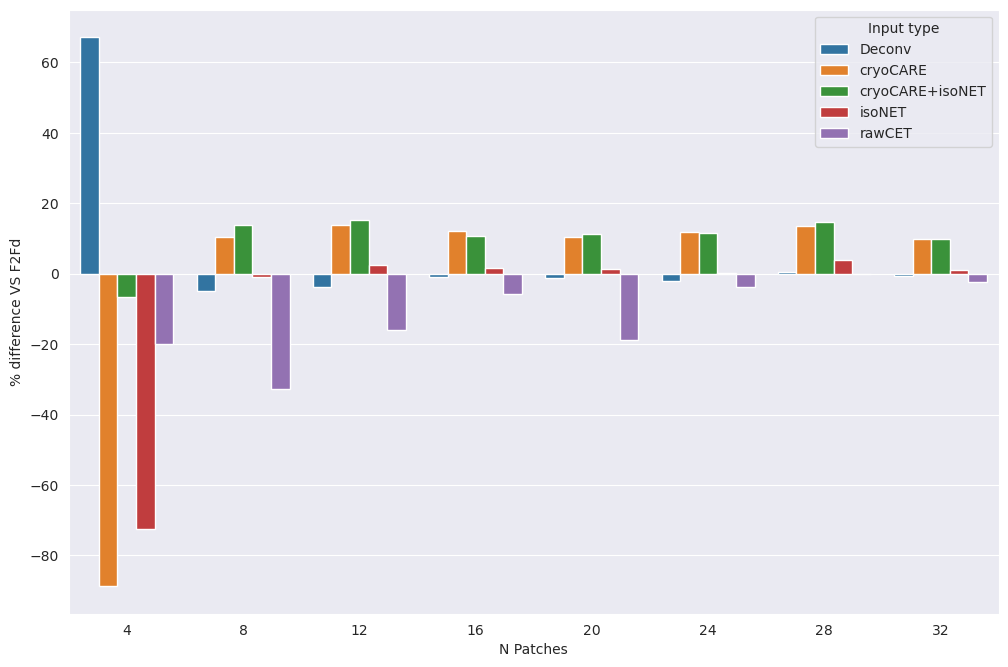

In [96]:
plt.figure(figsize=(12, 8), dpi=100)
aux_df = loss_means[(loss_means.input_type_!=ref_name)]
aux_df['n_patches_'] = aux_df.n_patches_.astype(str)
aux_df.rename(columns={'pct_diff_vs_%s' %ref_name:'%% difference VS %s' %ref_name, 'n_patches_':'N Patches', 'input_type_':'Input type'}, inplace=True)
sns.barplot(data=aux_df, x='N Patches', y='%% difference VS %s' %ref_name, hue='Input type')

In [21]:
loss_means[['input_type_', 'n_patches_', 'best_val_loss_epoch_count']].drop_duplicates()

,input_type_,n_patches_,best_val_loss_epoch_count
0,Deconv,4,5
1,Deconv,8,5
2,Deconv,12,5
3,Deconv,16,5
4,Deconv,20,5
5,Deconv,24,5
6,Deconv,28,5
7,Deconv,32,5
8,F2Fd,4,5
9,F2Fd,8,5


Text(0.5, 0, 'Number of training patches')

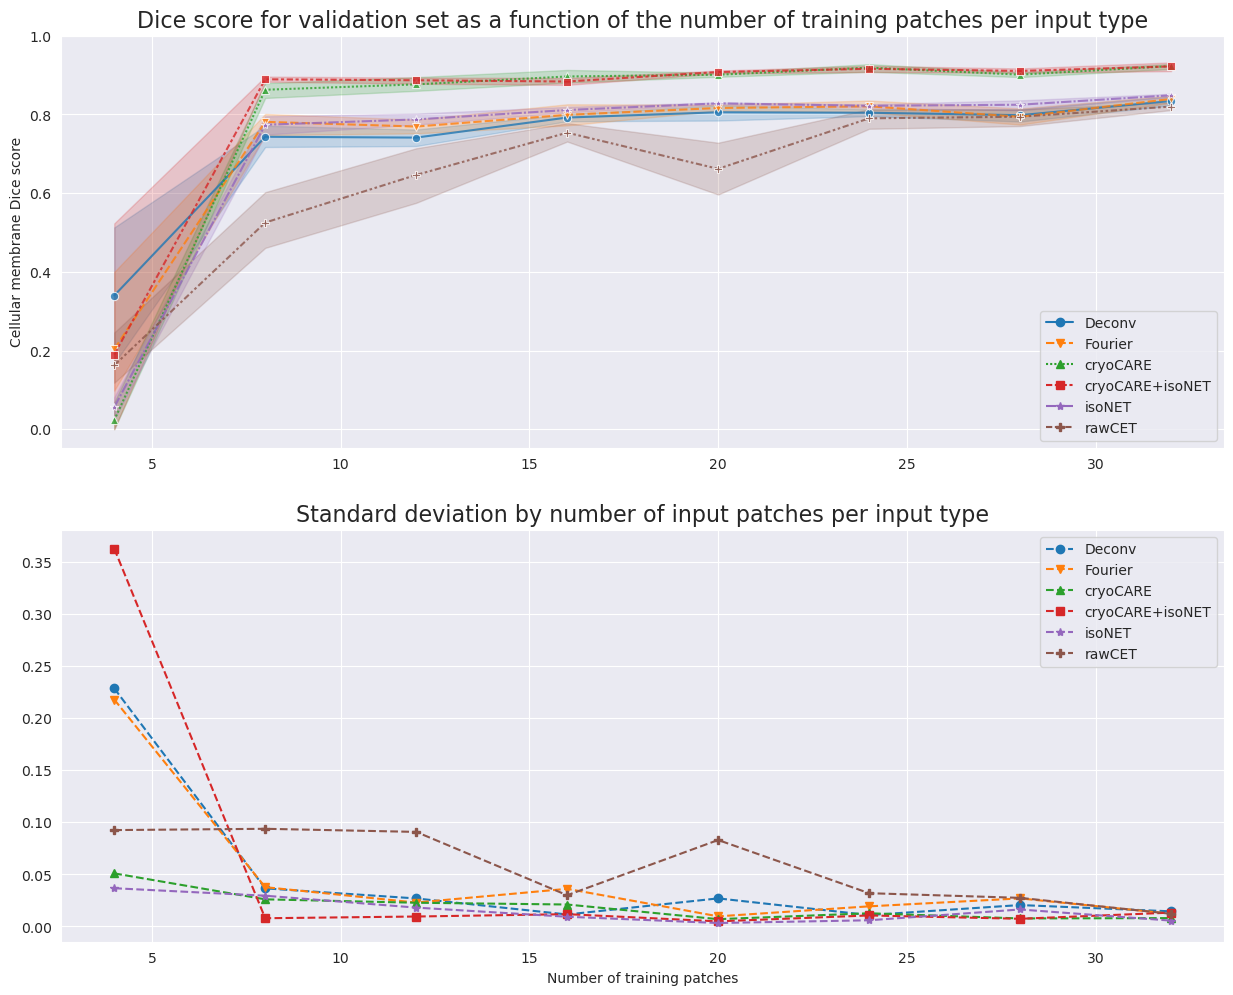

In [114]:
markers = ['o', 'v', '^', 's', '*', 'P']
sns.set_style("darkgrid")

fig, (ax_mean, ax_std) = plt.subplots(2, 1, figsize=(15, 12), dpi=100)
# plt.tight_layout()

sns.lineplot(x='n_patches', y='associated_val_class1_dice', hue='input_type', data=df_incremental, style='input_type', markers=markers, alpha=0.8, ax=ax_mean)
    
ax_mean.legend(loc='lower right')
ax_mean.set_title('Dice score for validation set as a function of the number of training patches per input type', size=16)
ax_mean.set_ylim(top=1)
ax_mean.set_ylabel('Cellular membrane Dice score')
ax_mean.set_xlabel('')


count = 0
for i, g in loss_means.set_index('n_patches_').groupby('input_type_'):
    g = g.reset_index()
    ax_std.plot(g['n_patches_'], g['associated_val_class1_dice_std'], label=i, marker=markers[count], linestyle='dashed')
    ax_std.legend()
    count+=1
ax_std.set_title('Standard deviation by number of input patches per input type', size=16)
ax_std.set_xlabel('Number of training patches')

Text(0.5, 0, 'Number of training patches')

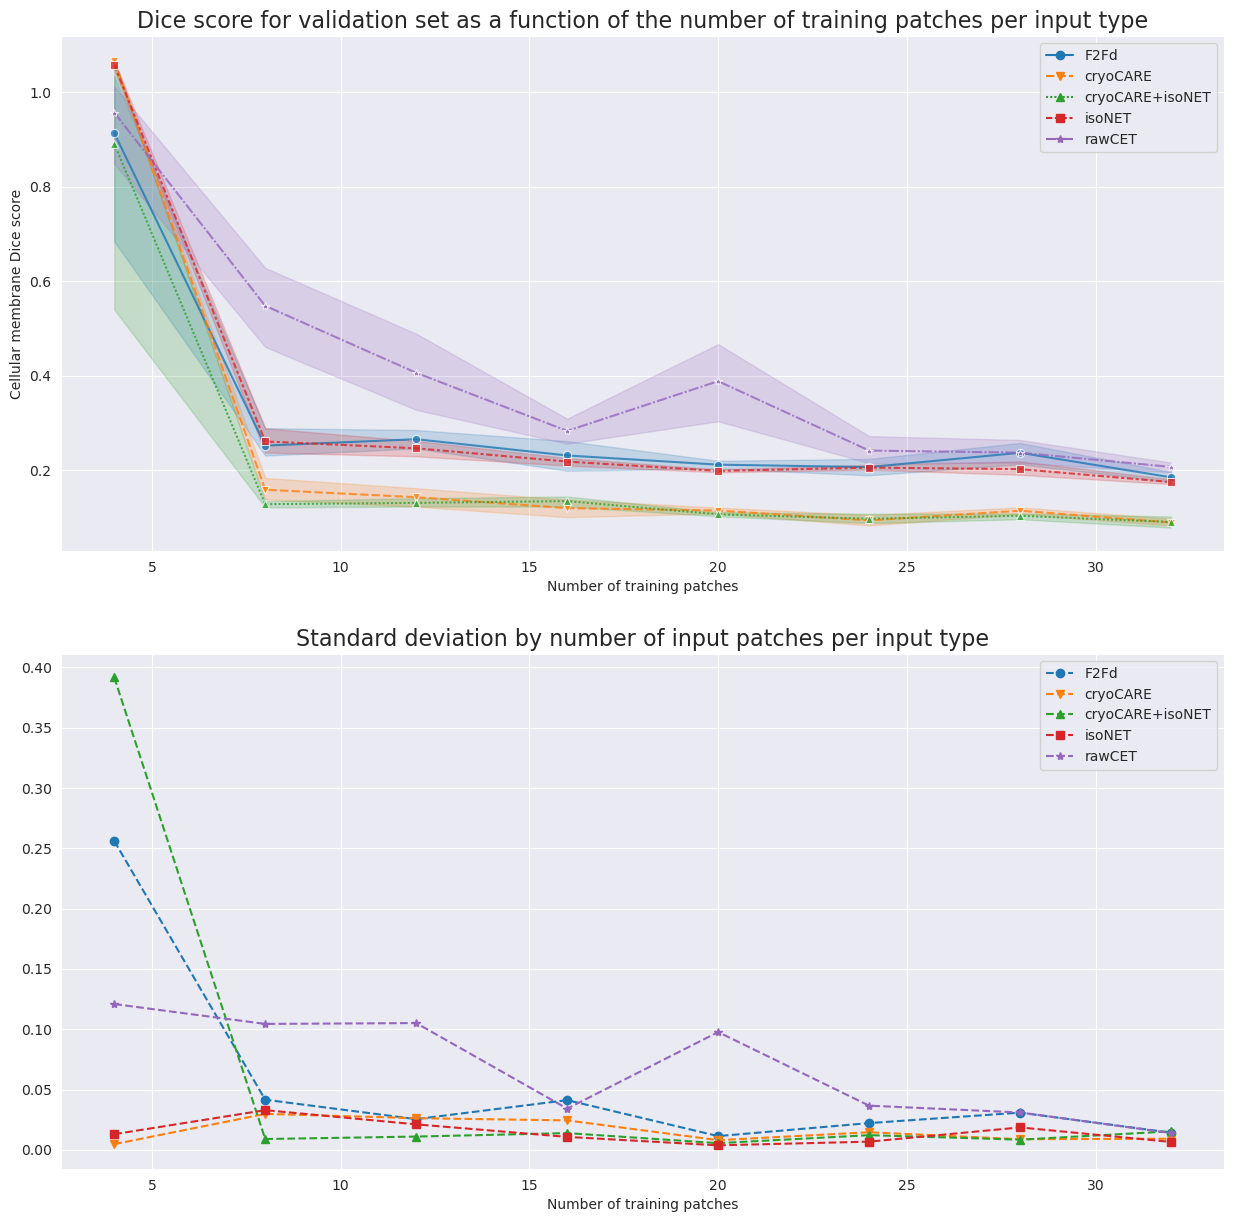

In [13]:
markers = ['o', 'v', '^', 's', '*']
sns.set_style("darkgrid")

fig, (ax_mean, ax_std) = plt.subplots(2, 1, figsize=(15, 15), dpi=100)
# plt.tight_layout()

sns.lineplot(x='n_patches', y='best_val_loss_epoch', hue='input_type', data=df_incremental, style='input_type', markers=markers, alpha=0.8, ax=ax_mean)
    
ax_mean.legend(loc='upper right')
ax_mean.set_title('Dice score for validation set as a function of the number of training patches per input type', size=16)

ax_mean.set_ylabel('Cellular membrane Dice score')
ax_mean.set_xlabel('Number of training patches')


count = 0
for i, g in loss_means.set_index('n_patches_').groupby('input_type_'):
    g = g.reset_index()
    ax_std.plot(g['n_patches_'], g['best_val_loss_epoch_std'], label=i, marker=markers[count], linestyle='dashed')
    ax_std.legend()
    count+=1
ax_std.set_title('Standard deviation by number of input patches per input type', size=16)
ax_std.set_xlabel('Number of training patches')

# Incremental models Dice on test set

In [31]:
from tomoSegmentPipeline.showcaseResults import *
import yaml

def load_model(logdir, DataParallel=False):
    "Returns loaded model from checkpoint and hyperparameters"
    if not logdir.endswith("/"):
        logdir = logdir + "/"

    with open(glob(logdir + "hparams.yaml")[0]) as f:
        hparams = yaml.load(f, Loader=yaml.BaseLoader)

    # yaml is stupid
    with open(logdir + "hparams.yaml") as f:
        s = f.readlines()
    
    Nclass = int(hparams['Ncl'])
    lr = float(hparams['lr'])
    pretrain_type = hparams['pretrain_type']
    if pretrain_type=='null':
        pretrain_type=None
               
    weight_decay = hparams['weight_decay']
    
    model = DeepFinder_model(
        Nclass, Tversky_loss, lr, weight_decay, pretrain_type=pretrain_type
    )

    ckpt_file = glob(logdir + "checkpoints/*.ckpt")
    assert len(glob(logdir + "checkpoints/*.ckpt")) == 1
    # if len(glob(logdir + "checkpoints/*.ckpt")) != 1:
    #     print(glob(logdir + "checkpoints/*.ckpt"), '\n')
    ckpt_file = ckpt_file[0]

    model = model.load_from_checkpoint(ckpt_file).cuda()
    if DataParallel:
        model = torch.nn.DataParallel(model)

    return model, hparams

def compute_dice1_testSet(testLoader, model):

    dice1 = []
    for patch, labels in testLoader:
        patch, labels = patch.cuda(), labels.cuda()
        pred = model(patch).detach().cpu()
        val = float(Tversky_index(pred.cuda(), labels.cuda())[1])
        dice1.append(val)

    dice1 = np.array(dice1).mean()

    torch.cuda.empty_cache()
    
    return dice1

In [77]:
dim_in=84

test_tomos = ["tomo38", "tomo04"]

logs_path = PARENT_PATH + 'data/membraneSegmentation/model_logs/incremental_models/logs/BaselineModel'
# logs_path = '/home/ubuntu/Thesis/data/membraneSegmentation/model_logs/incremental_models/logs/BaselineModel/Deconv/train02-03-17/'
logs_path = Path(logs_path)

model_info = []

flag_compute_testLoader = False
current_input_type = None

for f in tqdm(list(logs_path.rglob('version_*/'))):
    logdir_path = f.as_posix()
    
    model, hparams = load_model(logdir_path, True)
        
    model_file = glob(os.path.join(logdir_path, '*.model'))
    
    if len(model_file)==1:
        model_file_split = model_file[0].split('/')

        n_patches = model_file_split[-3]
        n_patches = int(n_patches.replace('nPatches_', ''))

        name, input_type, epochs, patch_size, lr, version = model_file_split[-1].split('_')
        epochs = int(epochs.replace('ep', ''))
        version = 'v'+version.replace('.model', '')

        # only compute testLoader when we change input type
        if current_input_type is None:
            current_input_type = input_type
            flag_compute_testLoader = True
        if current_input_type!=input_type:
            flag_compute_testLoader = True
            current_input_type = input_type

        if flag_compute_testLoader:
            print('Computing TestLoader for input type %s' %input_type)
            paths_testData, paths_testTarget = setup.get_paths(test_tomos, input_type)

            test_set = tomoSegment_dataset(
                paths_testData, paths_testTarget, dim_in, hparams['Ncl'], 0, False
            )

            testLoader = DataLoader(test_set, batch_size=30)

            flag_compute_testLoader = False

        dice1 = compute_dice1_testSet(testLoader, model)

        model_info.append([name, input_type, epochs, patch_size, n_patches, lr, version, dice1])
    else:
        print(f)

  0%|                                               | 0/240 [00:00<?, ?it/s]

Computing TestLoader for input type F2Fd


 17%|██████▎                               | 40/240 [02:29<12:07,  3.64s/it]

Computing TestLoader for input type cryoCARE+isoNET


 33%|████████████▋                         | 80/240 [05:09<10:29,  3.93s/it]

Computing TestLoader for input type cryoCARE


 50%|██████████████████▌                  | 120/240 [07:49<07:54,  3.96s/it]

Computing TestLoader for input type isoNET


 67%|████████████████████████▋            | 160/240 [10:40<05:29,  4.12s/it]

Computing TestLoader for input type rawCET


 83%|██████████████████████████████▊      | 200/240 [13:27<02:41,  4.04s/it]

Computing TestLoader for input type Deconv


100%|█████████████████████████████████████| 240/240 [16:17<00:00,  4.07s/it]


In [78]:
df_testSet = pd.DataFrame(model_info, columns=['name', 'input_type', 'epochs', 'patch_size', 'n_patches', 'lr', 'version', 'dice1'])

df_testSet = df_testSet[df_testSet.n_patches%4==0].sort_values(['input_type', 'n_patches'])
df_testSet = df_testSet[df_testSet.patch_size=='in84']
# df_testSet = df_testSet[df_testSet.input_type!='Deconv']


print(df_testSet.shape)
df_testSet.head()

(240, 8)


,name,input_type,epochs,patch_size,n_patches,lr,version,dice1
215,Baseline,Deconv,1000,in84,4,lr0.000100,v4,0.000084
216,Baseline,Deconv,1000,in84,4,lr0.000100,v2,0.000036
217,Baseline,Deconv,1000,in84,4,lr0.000100,v0,0.287928
218,Baseline,Deconv,1000,in84,4,lr0.000100,v3,0.242608
219,Baseline,Deconv,1000,in84,4,lr0.000100,v1,0.318967


In [115]:
df_testSet['input_type'] = df_testSet.input_type.map(lambda x: 'Fourier' if x=='F2Fd' else x).values

In [116]:
loss_means = df_testSet[df_testSet.n_patches%4==0].groupby(['input_type', 'n_patches']).agg({'dice1':['mean','std','count']
                                                                                            }).reset_index()
loss_means.columns = ['_'.join(col) for col in loss_means.columns]

ref_name = 'Fourier'
ref = loss_means[loss_means.input_type_==ref_name][['n_patches_', 'dice1_mean']]
ref.columns = ['n_patches_', 'pct_diff_vs_%s' %ref_name]
loss_means = loss_means.merge(ref, on='n_patches_')

loss_means['pct_diff_vs_%s' %ref_name] = 100*(loss_means.dice1_mean-loss_means['pct_diff_vs_%s' %ref_name])/loss_means['pct_diff_vs_%s' %ref_name]

loss_means.head()

,input_type_,n_patches_,dice1_mean,dice1_std,dice1_count,pct_diff_vs_Fourier
0,Deconv,4,1.699244e-01,1.574241e-01,5,73.183111
1,Fourier,4,9.811835e-02,2.157991e-01,5,0.000000
2,cryoCARE,4,1.472189e-07,1.137024e-07,5,-99.999850
3,cryoCARE+isoNET,4,1.489414e-01,3.330394e-01,5,51.797695
4,isoNET,4,4.999528e-05,1.035995e-04,5,-99.949046


<AxesSubplot:xlabel='N Patches', ylabel='% difference VS Fourier'>

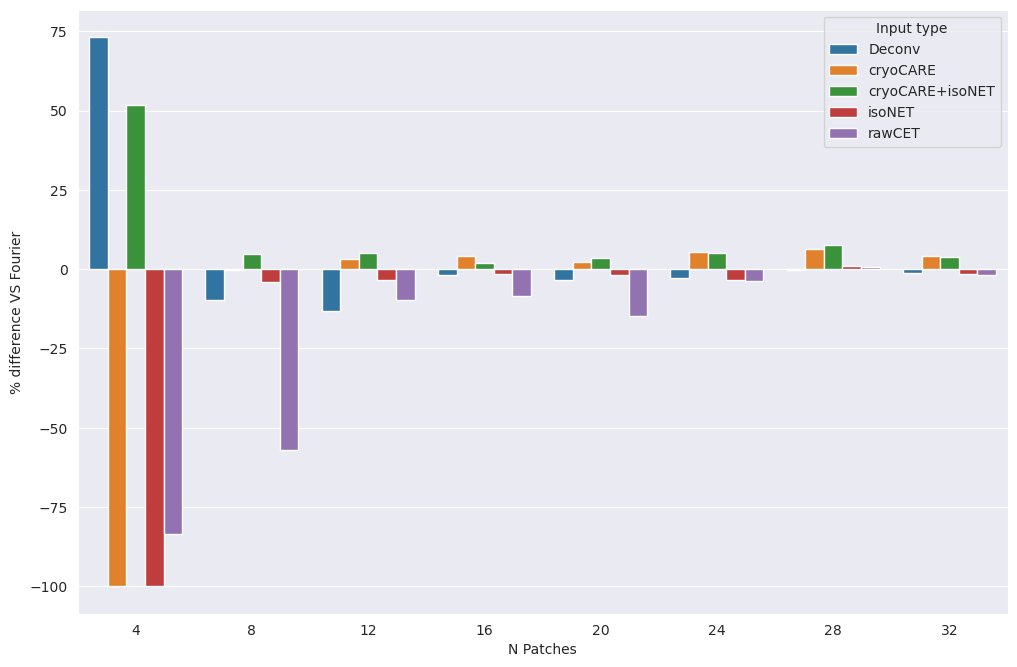

In [117]:
plt.figure(figsize=(12, 8), dpi=100)
aux_df = loss_means[(loss_means.input_type_!=ref_name) ]
aux_df['n_patches_'] = aux_df.n_patches_.astype(str)
aux_df.rename(columns={'pct_diff_vs_%s' %ref_name:'%% difference VS %s' %ref_name, 'n_patches_':'N Patches', 'input_type_':'Input type'}, inplace=True)
sns.barplot(data=aux_df, x='N Patches', y='%% difference VS %s' %ref_name, hue='Input type')

In [80]:
loss_means[['input_type_', 'n_patches_', 'dice1_count']].drop_duplicates()

,input_type_,n_patches_,dice1_count
0,Deconv,4,5
1,Deconv,8,5
2,Deconv,12,5
3,Deconv,16,5
4,Deconv,20,5
5,Deconv,24,5
6,Deconv,28,5
7,Deconv,32,5
8,F2Fd,4,5
9,F2Fd,8,5


Text(0.5, 0, 'Number of training patches')

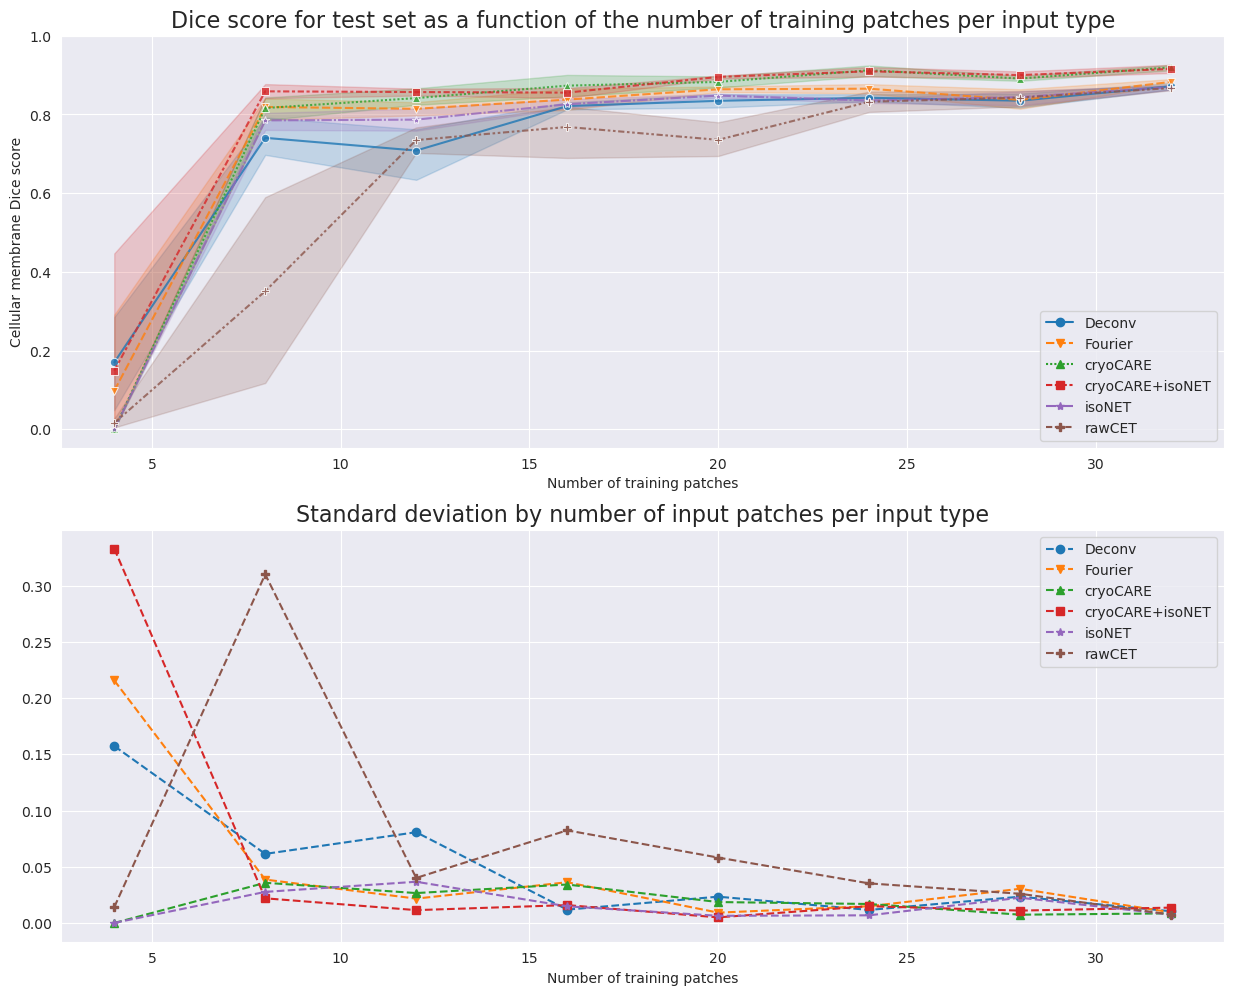

In [118]:
markers = ['o', 'v', '^', 's', '*', 'P']
sns.set_style("darkgrid")

fig, (ax_mean, ax_std) = plt.subplots(2, 1, figsize=(15, 12), dpi=100)
# plt.tight_layout()

sns.lineplot(x='n_patches', y='dice1', hue='input_type', data=df_testSet, style='input_type', markers=markers, alpha=0.8, ax=ax_mean)
    
ax_mean.legend(loc='lower right')
ax_mean.set_title('Dice score for test set as a function of the number of training patches per input type', size=16)
ax_mean.set_ylim(top=1)
ax_mean.set_ylabel('Cellular membrane Dice score')
ax_mean.set_xlabel('')


count = 0
for i, g in loss_means.set_index('n_patches_').groupby('input_type_'):
    g = g.reset_index()
    ax_std.plot(g['n_patches_'], g['dice1_std'], label=i, marker=markers[count], linestyle='dashed')
    ax_std.legend()
    count+=1
ax_std.set_title('Standard deviation by number of input patches per input type', size=16)
ax_std.set_xlabel('Number of training patches')

# Dice1 mean comparison

In [12]:
loss_means_val = df_incremental[df_incremental.n_patches%4==0].groupby(['input_type', 'n_patches']).agg({'best_val_loss_epoch':['mean','std','count'], 
                                                                'associated_val_class1_dice':['mean','std']}).reset_index()
loss_means_val.columns = ['_'.join(col) for col in loss_means_val.columns]

loss_means_val.head()

,input_type_,n_patches_,best_val_loss_epoch_mean,best_val_loss_epoch_std,best_val_loss_epoch_count,associated_val_class1_dice_mean,associated_val_class1_dice_std
0,Deconv,4,0.593737,NaN,1,0.472126,NaN
1,F2Fd,4,0.838638,0.331265,3,0.264142,0.284680
2,F2Fd,8,0.266338,0.051364,3,0.768160,0.047000
3,F2Fd,12,0.264818,0.017999,3,0.769620,0.016522
4,F2Fd,16,0.258456,0.022175,3,0.774718,0.019413


In [13]:
loss_means_test = df_testSet[df_testSet.n_patches%4==0].groupby(['input_type', 'n_patches']).agg({'dice1':['mean','std','count']
                                                                                            }).reset_index()
loss_means_test.columns = ['_'.join(col) for col in loss_means_test.columns]

loss_means_test.head()

,input_type_,n_patches_,dice1_mean,dice1_std,dice1_count
0,Deconv,4,0.287508,NaN,1
1,F2Fd,4,0.162382,0.278330,3
2,F2Fd,8,0.795700,0.048312,3
3,F2Fd,12,0.807245,0.018770,3
4,F2Fd,16,0.805390,0.014451,3


# Mean best dice predictions Baseline Models

In [21]:
logs_path = PARENT_PATH + 'models_1/logs/BaselineModel/'
logs_path = Path(logs_path)

model_info = []


for f in logs_path.rglob('*/version_*/'):
    logdir_path = f.as_posix()
    
    model_file = glob(os.path.join(logdir_path, '*.model'))
    if len(model_file)==1:
        model_file = model_file[0]
        
        model_file_split = model_file.split('/')
        
        input_type = model_file_split[-4]
        
        name, epochs, patch_size, lr, version = model_file_split[-1].split('_')
        epochs = int(epochs.replace('ep', ''))
        version = 'v'+version.replace('.model', '')

        events_path = glob(os.path.join(logdir_path, 'events.*'))[0]
        event_acc = EventAccumulator(events_path)
        event_acc.Reload()

        _, _, values_valLoss = zip(*event_acc.Scalars('hp/val_loss_epoch'))
        best_val_loss_epoch = np.min(values_valLoss)
        best_val_loss_epoch_idx = np.argmin(values_valLoss) #index starts count at 0

        effective_epochs = len(values_valLoss)

        _, _, values_dice = zip(*event_acc.Scalars('hp/val_dice_epoch'))
        _, _, values_trainLoss = zip(*event_acc.Scalars('hp/train_loss_epoch'))

        associated_val_class1_dice = float(values_dice[best_val_loss_epoch_idx])
        associated_train_loss_epoch = float(values_trainLoss[best_val_loss_epoch_idx])

        train_set = str(train_patchCounts)[1:-1].replace(',', ' ')
        train_set = train_set.replace(',', ' -').replace("'", "")

        validation_set = str(val_patchCounts)[1:-1].replace(',', ' ')
        validation_set = validation_set.replace(',', ' -').replace("'", "")

        epochs_str = "%i out of %i" %(effective_epochs, 1000)

        model_info.append([name, input_type, epochs_str, patch_size, lr, version, best_val_loss_epoch, associated_val_class1_dice])
    
    else:
        pass

In [13]:
df_model = pd.DataFrame(model_info, columns=['name', 'input_type', 'epochs', 'patch_size', 'lr', 'version', 'best_val_loss_epoch',
                                             'associated_val_class1_dice'])
print(df_model.shape)
df_model.head()

(18, 8)


,name,input_type,epochs,patch_size,lr,version,best_val_loss_epoch,associated_val_class1_dice
0,Baseline,rawCET,215 out of 1000,in84,lr0.000300,v0,0.205240,0.820816
1,Baseline,rawCET,1000 out of 1000,in84,lr0.000100,v1,0.274763,0.760572
2,Baseline,rawCET,346 out of 1000,in96,lr0.000100,v4,0.289667,0.730407
3,Baseline,rawCET,393 out of 1000,in96,lr0.000100,v3,0.253714,0.765400
4,Baseline,rawCET,301 out of 1000,in56,lr0.000100,v2,0.231046,0.789884


In [15]:
df_model[['name', 'input_type', 'version']].drop_duplicates()

,name,input_type,version
0,Baseline,rawCET,v0
1,Baseline,rawCET,v1
2,Baseline,rawCET,v4
3,Baseline,rawCET,v3
4,Baseline,rawCET,v2
5,Baseline,cryoCARE+isoNET,v0
6,Baseline,cryoCARE+isoNET,v1
7,Baseline,cryoCARE+isoNET,v3
8,Baseline,cryoCARE+isoNET,v2
9,Baseline,isoNET,v0


<AxesSubplot:xlabel='input_type', ylabel='associated_val_class1_dice'>

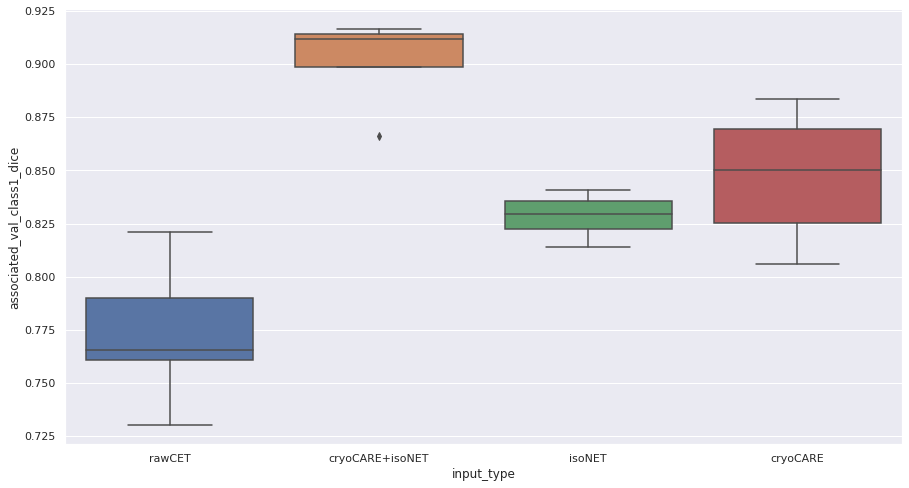

In [14]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.boxplot(x='input_type', y='associated_val_class1_dice', data=df_model)

# Mean best dice predictions for LowBaseline Models

In [31]:
logs_path = PARENT_PATH + 'models_1/logs/LowBaselineModel/'
logs_path = Path(logs_path)

model_info = []


for f in logs_path.rglob('*/version_*/'):
    logdir_path = f.as_posix()
    
    model_file = glob(os.path.join(logdir_path, '*.model'))
    if len(model_file)==1:
        model_file = model_file[0]
        
        model_file_split = model_file.split('/')
        
        input_type = model_file_split[-4]
        train_tomo = model_file_split[-3]
        
        name, epochs, patch_size, lr, version = model_file_split[-1].split('_')
        epochs = int(epochs.replace('ep', ''))
        version = 'v'+version.replace('.model', '')

        events_path = glob(os.path.join(logdir_path, 'events.*'))[0]
        event_acc = EventAccumulator(events_path)
        event_acc.Reload()

        _, _, values_valLoss = zip(*event_acc.Scalars('hp/val_loss_epoch'))
        best_val_loss_epoch = np.min(values_valLoss)
        best_val_loss_epoch_idx = np.argmin(values_valLoss) #index starts count at 0

        effective_epochs = len(values_valLoss)

        _, _, values_dice = zip(*event_acc.Scalars('hp/val_dice_epoch'))
        _, _, values_trainLoss = zip(*event_acc.Scalars('hp/train_loss_epoch'))

        associated_val_class1_dice = float(values_dice[best_val_loss_epoch_idx])
        associated_train_loss_epoch = float(values_trainLoss[best_val_loss_epoch_idx])

        train_set = str(train_patchCounts)[1:-1].replace(',', ' ')
        train_set = train_set.replace(',', ' -').replace("'", "")

        validation_set = str(val_patchCounts)[1:-1].replace(',', ' ')
        validation_set = validation_set.replace(',', ' -').replace("'", "")

        epochs_str = "%i out of %i" %(effective_epochs, 1000)

        model_info.append([name, train_tomo, input_type, epochs_str, patch_size, lr, version, best_val_loss_epoch, associated_val_class1_dice])
    
    else:
        pass

In [32]:
df_model = pd.DataFrame(model_info, columns=['name', 'train_tomo', 'input_type', 'epochs', 'patch_size', 'lr', 'version', 'best_val_loss_epoch',
                                             'associated_val_class1_dice'])
print(df_model.shape)
df_model.head()

(54, 9)


,name,train_tomo,input_type,epochs,patch_size,lr,version,best_val_loss_epoch,associated_val_class1_dice
0,LowBaseline,train17,rawCET,107 out of 1000,in84,lr0.000300,v0,0.773063,0.295680
1,LowBaseline,train17,rawCET,183 out of 1000,in84,lr0.000100,v1,0.783792,0.295086
2,LowBaseline,train17,rawCET,138 out of 1000,in96,lr0.000100,v4,0.778582,0.285223
3,LowBaseline,train17,rawCET,446 out of 1000,in96,lr0.000100,v3,0.710688,0.334793
4,LowBaseline,train17,rawCET,292 out of 1000,in56,lr0.000100,v2,0.734075,0.314304


In [37]:
df_model[['train_tomo', 'input_type', 'version']].drop_duplicates()

,train_tomo,input_type,version
0,train17,rawCET,v0
1,train17,rawCET,v1
2,train17,rawCET,v4
3,train17,rawCET,v3
4,train17,rawCET,v2
5,train02,rawCET,v0
6,train02,rawCET,v1
7,train02,rawCET,v4
8,train02,rawCET,v3
9,train02,rawCET,v2


<AxesSubplot:xlabel='input_type', ylabel='associated_val_class1_dice'>

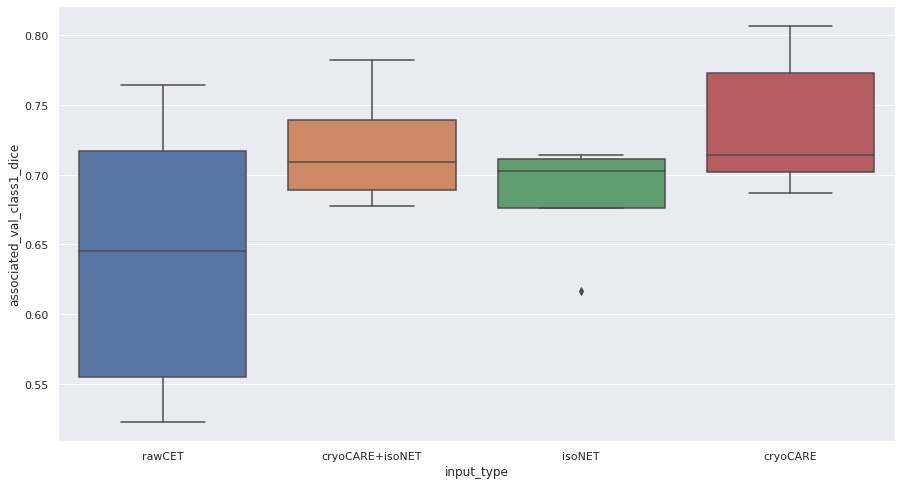

In [35]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.boxplot(x='input_type', y='associated_val_class1_dice', data=df_model[df_model.train_tomo=='train02'])

In [ ]:
# isolated analysis depending on reconstruction (denoising) process